In [1]:
!pip install datasets transformers evaluate imbalanced-learn umap-learn wandb GPUtil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [3]:
import pandas as pd

In [4]:
from datasets import load_dataset

health_fact = load_dataset('health_fact')

Generating train split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1225 [00:00<?, ? examples/s]

Dataset health_fact downloaded and prepared to /root/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
# Filter out instances with a -1 label
health_fact['train'] = health_fact['train'].filter(lambda x: x['label'] != -1)
health_fact['validation'] = health_fact['validation'].filter(lambda x: x['label'] != -1)
health_fact['test'] = health_fact['test'].filter(lambda x: x['label'] != -1)

Filter:   0%|          | 0/9832 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1225 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1235 [00:00<?, ? examples/s]

## Tokenizing the Dataset

Transformers are particularly good at handling natural language but we need to tokenize the text so that it can be used by an ML classifier.  Distilbert is a slimmed down version of the Bert transformer that will allow us to train a little more quickly.  We start by loading the tokenizer and tokenizing the entire dataset.

For the moment, let us assume that the explanation has all the information needed to make a judgement on the veracity of the claim.

In [6]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [7]:
def tokenize(batch):
    return tokenizer(batch['explanation'], truncation=True, padding=True)

In [8]:
health_fact_encoded = health_fact.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/9804 [00:00<?, ? examples/s]

Map:   0%|          | 0/1233 [00:00<?, ? examples/s]

Map:   0%|          | 0/1214 [00:00<?, ? examples/s]

Now let's get the distilbert model itself and put it onto the GPU assuming we have access.

In [9]:
import torch
from transformers import AutoModel

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The distilbert model is pre-trained and we can have a look at how the pre-trained model represents the different classes in our dataset by extracting the hidden states from the model for our dataset.

In [10]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [11]:
health_fact_encoded.set_format('torch', columns=["input_ids", "attention_mask", "label"])

In [12]:
health_fact_hidden = health_fact_encoded.map(extract_hidden_states, batched=True, batch_size=100)

Map:   0%|          | 0/9804 [00:00<?, ? examples/s]

Map:   0%|          | 0/1233 [00:00<?, ? examples/s]

Map:   0%|          | 0/1214 [00:00<?, ? examples/s]

With the hidden states available we can now create X input and y targets for the train and validation sets.

In [13]:
import numpy as np

X_train = np.array(health_fact_hidden["train"]["hidden_state"])
X_valid = np.array(health_fact_hidden["validation"]["hidden_state"])
y_train = np.array(health_fact_hidden["train"]["label"])
y_valid = np.array(health_fact_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((9804, 768), (1214, 768))

Let's use umap to project the high dimensional space of the transformers hidden layer into a 2-dimensional space so that we can view how the different classes look in that regard.

In [14]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,1.444077,1.508590,0
1,8.670480,5.059971,1
2,8.357557,5.372401,1
3,7.615118,3.886449,2
4,7.685752,3.000345,2


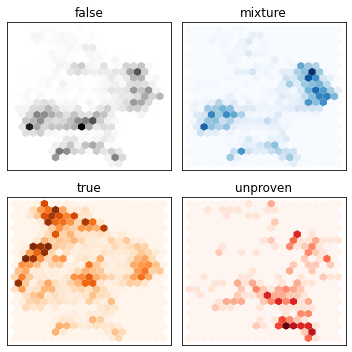

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(5,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Greens"]
labels = health_fact["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

Here we can see a representation of the different clases. True and False clearly have some distinctions.  Perhaps predictly mixtures have a combination of true and false and unproven is different again.  This at least suggests that we should be able to train a model to make a distinction between the classes based on how distilbert is representing the data.

Let's start by training a logistic regression model on the hidden states to get a baseline.

In [16]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6845140032948929

This is better than chance and a fair bit better given that we have a multiclass dataset that is somewhat unbalanced.  Let's see how the sklearn DummyClassifier compares using a just predict the most frequent class.

In [17]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.5181219110378913

This is much lower, so using the Distilbert embeddings seems like a good start.  We can also look at a confusion matrix to see how the logistic regression model relates the true and predicted labels.

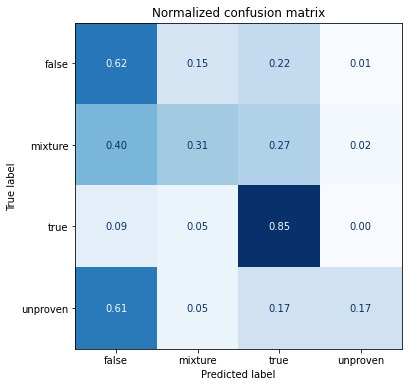

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)


Here we see that the true and false labels are managed reasonably well, but there is confusion over the mixture and unproven labels which are more often identified as false.

## Fine Tuining the Distilbert Model

We can likely get better performance than the logistic regression model by tuning the Distilbert model itself.

In [19]:
from transformers import AutoModelForSequenceClassification

num_labels = 4
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Let's assess the performance of the model as we tune it on accuracy and F1 scores.

In [20]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [21]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(health_fact_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-health-fact"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  load_best_model_at_end = True,
                                  log_level="error")


In [22]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [23]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 | 30% | 10% |


In [24]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

class CustomEarlyStoppingCallback(EarlyStoppingCallback):
    def __init__(self, early_stopping_patience=3):
        super().__init__(early_stopping_patience=early_stopping_patience)

early_stopping_callback = CustomEarlyStoppingCallback(early_stopping_patience=1)
        
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=health_fact_encoded["train"],
                  eval_dataset=health_fact_encoded["validation"],
                  tokenizer=tokenizer,
                  callbacks=[early_stopping_callback],)
trainer.train();

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.830700,0.709819,0.710049,0.700934
2,0.663000,0.683614,0.721582,0.704331


Training for just a couple of epochs we see we can get up to a ~0.73 accuracy on the validation set.

In [25]:
trainer.save_model('distilbert')

In [26]:
preds_output = trainer.predict(health_fact_encoded["validation"])


In [27]:
preds_output.metrics

{'test_loss': 0.6836138367652893,
 'test_accuracy': 0.7215815485996705,
 'test_f1': 0.7043311171275333,
 'test_runtime': 19.6655,
 'test_samples_per_second': 61.733,
 'test_steps_per_second': 1.932}

In [28]:
y_preds = np.argmax(preds_output.predictions, axis=1)


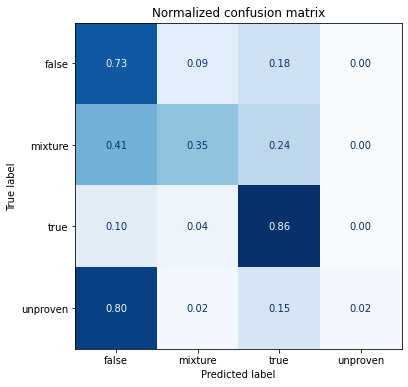

In [29]:
plot_confusion_matrix(y_preds, y_valid, labels)

Looking again at the confusion matrix we can see that our tuned distilbert model is not a bit more confident about the false class, true is approximately the same, but the mixture and unproven classes are being even more confused with the false class

We can explore the model's predictions a little further by sorting the validation samples in terms of model loss.

In [30]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [31]:
health_fact_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
health_fact_encoded["validation"] = health_fact_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)


Map:   0%|          | 0/1214 [00:00<?, ? examples/s]

In [32]:
def label_int2str(row):
    if row == -1:
        return 'invalid'
    return health_fact["train"].features["label"].int2str(row)

In [33]:
health_fact_encoded.set_format("pandas")
cols = ["claim", "explanation", "label", "predicted_label", "loss", "date_published", "claim_id"]
df_test = health_fact_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

Having created a dataframe with the texts/losses and predicted/true labels we can have a look at where the model is making mistakes.

In [34]:
from IPython.display import display, HTML

def wrap_df_text(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))

df_test['claim'] = df_test['claim'].str.wrap(30)
df_test['explanation'] = df_test['explanation'].str.wrap(30)
wrap_df_text(df_test.sort_values("loss", ascending=False).head(10))


,claim,explanation,label,predicted_label,loss,date_published,claim_id
531,"Russia used ""GPS spoofing"" tocause the USS John McCain tocollide with a merchantvessel.","In the wake of the USS McCaincollision, the chief of NavalOperations “ordered aworldwide operational pause asfleet commanders assesspractices.”",unproven,true,4.744848,"August 22, 2017",34361
9,Results mixed on Merck’s newpainkiller,"Ethical investors, includingthe Church of England, plan toextend their campaign forminers and other bigbusinesses to stop fundingindustry associations thatblock progress on U.N. goalsto curb climate change, theysaid on Tuesday.",mixture,true,4.542132,"November 13, 2006",11514
631,Viral image Says Harvardscientists say the coronavirusis “spreading so fast that itwill infect 70% of humanitythis year.”,An epidemiologist at HarvardUniversity projects 40%-70% ofadults could catch coronavirusin the coming year.,mixture,true,4.523160,"March 11, 2020",26702
249,FDA Approves Cystic FibrosisDrug,Firefighters battlingwildfires in Australia madethe most of cooler weather onSunday to access badly burnedtowns and contain blazesbefore the expected return ofhotter conditions at the endof the week.,mixture,true,4.507700,"February 1, 2012",9810
339,The race to create a new classof ovarian cancer drugs heatsup,"Boeing Co’s Starlinerastronaut spacecraft landed inthe New Mexico desert onSunday, the company said,after faulty software forcedofficials to cut short anunmanned mission aimed attaking it to the InternationalSpace Station.",mixture,true,4.365164,"October 14, 2016",9553
790,Eating more vegetable proteinmay protect against earlymenopause,Australian officials tookadvantage of better weather onMonday to reopen roads blockedby wildfires and move somepeople to safety althoughthick smoke stalled rescueefforts and hundreds of peopleremained stranded.,mixture,true,4.359258,"June 28, 2017",9128
544,The Tim Allen show 'Last ManStanding' was cancelled due tothe star's political beliefs.,"In May 2018, Fox announcedthey would be bringing backLast Man Standing for the2018-19 television season.",unproven,true,4.130334,"May 18, 2017",34403
987,"A treatment for a seriousdisease that costs $900 inIndia is sold for $84,000 inthe United States because ofcorporate greed.","A French court has ruled thatMonsanto was liable for thesickness of a farmer whoinhaled one of itsweedkillers, in another legalsetback for the Bayer-ownedbusiness over health claims.",mixture,true,4.064766,"May 2, 2016",28855
904,"We have no [trade] deficit[with Canada], but thatdoesn't include energy andtimber. But when you do welose $17 billion a year.""","This Sunday in South Africa,an accountant, an entrepreneurand a boxing executive areamong 20 friends running theCape Town marathon - withsaplings strapped to theirbacks.",false,true,3.883637,"March 15, 2018",41939
203,A teenaged girl was druggedand nearly abducted in aDillard's department store byfellow teens working on behalfof sex traffickers.,"Moreover, the referencedarticle linked described apolice crackdown on a DentonCounty human traffickingoperation that did not involveabductions of victims fromdepartment store restrooms,the use of heroin to drugunwitting teen shoppers, theintervention of a potentialvictim’s mother, the use offellow teen girls asrecruiting agents, or asituation that was haltedbefore anyone was harmed. Aseparate article about the2014 operation reportedseveral arrests but made nomention of young girls beingemployed as operatives of asex trafficking-relatedabduction ring.",unproven,false,3.837072,"June 30, 2015",34669


What's interesting to note here is that we have instances in the dataset where the explanation seems completely unrelated to the claim.  Note the rows with claim ids 9810 and 9128 and 41939.  

It's also interesting to see claims like claim id 34403 where the explanation is very short and doesn't make any sense without the information in the claim text.

This strongly suggests that the model will struggle with short explanations, and those where the explanation appears unrelated to the claim.

Conversely we can look at the claims that the model does well on, and as we can see below, these are all firmly in the true category

In [35]:
wrap_df_text(df_test.sort_values("loss", ascending=True).head(10))

,claim,explanation,label,predicted_label,loss,date_published,claim_id
533,Senate panel: NY needsaddiction treatmentprofessionals.,A New York state Senate panelis recommending the state domore to recruit and trainhealth care professionals whowork with recovering addicts.,true,true,0.028637,,5248
994,Task force offers guidelinesto treat rat lungworm disease.,"A task force of HawaiiGovernor David Ige’s announcednew preliminary guidelines tohelp physicians diagnose,treat and manage rat lungwormdisease.",true,true,0.029388,,6670
698,Hassan highlights access tohealth care for femaleveterans.,The director of a nationalveterans’ organization isjoining U.S. Sen. MaggieHassan to highlight thestruggles female veterans facein accessing health care.,true,true,0.029564,,5800
220,Lawyers making final pitchesin Flint water criminal case.,A judge is hearing keyarguments in the mostsignificant criminal caserelated to Flint’s lead-contaminated water.,true,true,0.030063,,5459
736,Medical school get $3.7M toaddress geriatric careshortage.,"The University of NebraskaMedical Center has received afive-year, $3.7 million grantto address the loomingshortage of doctors whospecialize in the care ofolder adults.",true,true,0.030801,,6320
706,Ebola 'no longer incurable' asCongo trial finds drugs boostsurvival.,Scientists are a step closerto being able to cure thedeadly Ebola hemorrhagic feverafter two experimental drugsshowed survival rates of asmuch as 90% in a clinicaltrial in Congo.,true,true,0.030916,"August 12, 2019",833
1174,"Tick, tick, tick: Alaskabraces for invading parasites.",Health and wildlife officialsare taking steps to preparefor potentially dangerousparasites that could gain afoothold because of Alaska’swarming climate.,true,true,0.030946,,4046
312,"Hepatitis A confirmed atRedfield, Arkansas, diner.",Health officials are againwarning of a possiblehepatitis A exposure after anemployee at a central Arkansasdiner tested positive for thedisease.,true,true,0.031382,,6367
612,Gillibrand to discuss federaleffort to combat Lyme disease.,U.S. Sen. Kristen Gillibrandwill be in upstate New York todiscuss efforts by the federalgovernment to battle Lymedisease.,true,true,0.031610,,4064
420,Public urged to avoid wildanimals after rabid skunkcases.,Suburban Detroit officials areurging the public to stay awayfrom wild animals after nearlya dozen cases of rabies havebeen confirmed in skunks.,true,true,0.031730,,3624


## Conclusion

A transformer tuned on the explanation text can give reasonable performance above a baseline, but it seems likely that the claim text is needed as well to deal with certain tricky cases.

We also have the issue of what seems like dirty data where the claim is completely unrelated to the explanation, suggesting further cleaning of the data would make sense.  Still having the claim text included might also help the model in this case since the mismatch between claim and explanation text might indicate that a true label is unlikely, although we haven't analyzed the frequency of the different labels in the mistmatch case.  

Identifying all the mistmatch cases might be timeconsuming although perhaps we could identify all those claims where the explanation/main_text had only minimally matching keywords?